# Project Stage - IV (Basic Machine Learning)
#### Project Team 2
### Goals
The goal of Stage IV is to utlize machine learning and statistical models to predict the trend of COVID-19 cases / deaths.

### Team Tasks:
- Develop Linear and Non-Linear (polynomial) regression models for predicting cases and deaths in US.
    - Start your data from the first day of infections in US. X-Axis - number of days since the first case, Y-Axis - number of new cases and deaths. (**Logan, Sage**)
    - Calculate and report Root Mean Square Error (RMSE) for your models (linear and non-linear). Discuss bias versus variance tradeoff.
    - Plot trend line along for the data along with the forecast of 1 week ahead.
    - Describe the trends as compared to other countries.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image
from sklearn.linear_model import LinearRegression


from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

Read in the cases csv and deaths csv

In [2]:
cases = pd.read_csv("../../../data/stage_2/covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../../../data/stage_2/covid_deaths_usafacts.csv")
deaths

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-08-07,2021-08-08,2021-08-09,2021-08-10,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,114,114,114,114,114,114,114,114,114,114
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,330,330,330,332,338,342,344,344,344,347
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,63,63,63,63,64,64,65,65,65,65
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,66,66,66,66,67,67,67,67,67,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,45,45,45,45,45,45,45,45,45,45
3189,56039,Teton County,WY,56,0,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
3190,56041,Uinta County,WY,56,0,0,0,0,0,0,...,14,14,14,14,14,14,14,14,14,14
3191,56043,Washakie County,WY,56,0,0,0,0,0,0,...,26,26,26,26,26,26,26,26,26,26


Crop the df from the first day to the end in cases and deaths.

In [3]:
# crop the first 4 columns
cases_cropped = cases.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
# The first day of infections will be the first date column that has a sum > 0
cases_cropped.sum() # 2020-01-22, the first recorded day has the first case.

deaths_cropped = deaths.drop(columns=['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1)
deaths_cropped.sum().head(20) # 2020-02-06, the first death, 15 days after the first case

2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
2020-01-27    0
2020-01-28    0
2020-01-29    0
2020-01-30    0
2020-01-31    0
2020-02-01    0
2020-02-02    0
2020-02-03    0
2020-02-04    0
2020-02-05    0
2020-02-06    1
2020-02-07    1
2020-02-08    1
2020-02-09    1
2020-02-10    1
dtype: int64

Get only the column names. 
Code for extracting column names in for-loop: https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/ 
Code for extending list size : https://www.w3schools.com/python/python_lists_add.asp

In [4]:
extraneous_columns = []
for col in deaths_cropped.iloc[:,:14].columns:
    extraneous_columns.append(col)
extraneous_columns
# Note: I am not sure if this is necessary but I will crop the deaths df from the first recorded death
# Update : Logan and I (Sage) believe that this is necessary, to create cropped dataframes for cases and deaths
deaths_cropped = deaths_cropped.drop(columns=extraneous_columns)

In [5]:
deaths_cropped_total = deaths_cropped.sum()
cases_cropped_total = cases_cropped.sum()

Alter the column values to be *new* cases and deaths

In [6]:
# Cases
# Code borrowed from Stage II Team Deliverable
new_cases = pd.DataFrame()

for column in range(1,573):
  new_cases[column] = cases_cropped.iloc[:,column] - cases_cropped.iloc[:,column-1] 

In [7]:
new_cases_trial = new_cases.sum()
new_cases_trial = new_cases_trial.to_frame()
new_cases_trial = new_cases_trial.drop([1]) # drop the first row since 2nd row has first reported case
new_cases_trial

,0
2,1
3,0
4,3
5,1
6,0
...,...
568,141366
569,152304
570,34148
571,19392


In [8]:
new_cases_trial = new_cases_trial.reset_index()
new_cases_trial = new_cases_trial.rename(columns={"index": "days_since", 0 : "new_cases"})
new_cases_trial['days_since'] = new_cases_trial['days_since'].apply(lambda x: x-2)
new_cases_trial

,days_since,new_cases
0,0,1
1,1,0
2,2,3
3,3,1
4,4,0
...,...,...
566,566,141366
567,567,152304
568,568,34148
569,569,19392


In [9]:
# Deaths
# Code below borrowed from Stage II Team Deliverable
new_deaths = pd.DataFrame()

for column in range(1,559):
  new_deaths[column] = deaths_cropped.iloc[:,column] - deaths_cropped.iloc[:,column-1]

In [10]:
new_deaths_trial = new_deaths.sum()
new_deaths_trial = new_deaths_trial.to_frame()
# new_deaths_trial = new_deaths_trial.drop([1]) # drop the first row since 2nd row has first reported case
new_deaths_trial

,0
1,1
2,0
3,0
4,0
5,0
...,...
554,638
555,886
556,154
557,45


In [11]:
new_deaths_trial = new_deaths_trial.reset_index()
new_deaths_trial = new_deaths_trial.rename(columns={"index": "days_since", 0 : "new_deaths"})
new_deaths_trial['days_since'] = new_deaths_trial['days_since'].apply(lambda x: x-1)
new_deaths_trial

,days_since,new_deaths
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
553,553,638
554,554,886
555,555,154
556,556,45


X is the days since the first cases and Y is the number of new cases.

### Cases

In [12]:
x = new_cases_trial['days_since']
y = new_cases_trial['new_cases']

lm = smf.ols(formula= 'new_cases ~ days_since', data = new_cases_trial).fit()

lm.params

Intercept     31249.001586
days_since      112.583501
dtype: float64

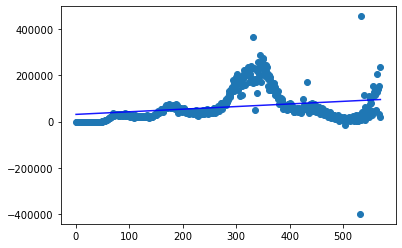

In [14]:
plt.scatter(new_cases_trial.days_since, new_cases_trial.new_cases)
x = pd.DataFrame({'days_since': np.linspace(new_cases_trial.days_since.min(), new_cases_trial.days_since.max(), 571)})
X_new = pd.DataFrame({'days_since':[572,573,574,575,576,577,578]})


plt.plot(new_cases_trial.days_since, lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % lm.rsquared, alpha=0.9)

#### Linear cases Bias vs. Variance
For every passing day there is another 112 cases on average. This line is very high bias, low variance. This line does a poor job of identifying peaks in the data.

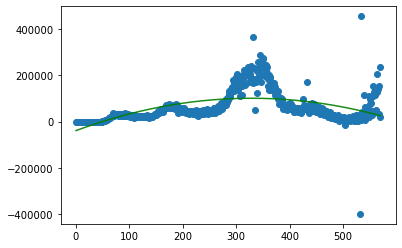

In [20]:
plt.scatter(new_cases_trial.days_since, new_cases_trial.new_cases)

lm_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=new_cases_trial).fit()
plt.plot(new_cases_trial.days_since, lm_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % lm_poly_2.rsquared, alpha=0.9)

In [21]:
lm_poly_2.params

Intercept              -38627.759670
days_since                849.421054
I(days_since ** 2.0)       -1.292697
dtype: float64

#### Polynomial cases Bias vs. Variance
The line suffers from high bias and low variance. We can see that from the many peaks and troughs in the data and the outliers are not affecting the line greatly. This line does a better job of a single peak in the data.

In [22]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     45.97
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           3.02e-11
Time:                        00:56:41   Log-Likelihood:                -7140.7
No. Observations:                 571   AIC:                         1.429e+04
Df Residuals:                     569   BIC:                         1.429e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.125e+04   5467.180      5.716      0.000    2.05e+04     4.2e+04
days_since   112.5835     16.606      6.780      0.000      79.967     145.200
==============================================================================
Omnibus:                      144.502   Durbin-Watson:                   0.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1620.688
Skew:                           0.765   Prob(JB):                         0.00
Kurtosis:                      11.111   Cond. No.                         658.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
lm_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     115.4
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           8.75e-43
Time:                        00:56:46   Log-Likelihood:                -7065.5
No. Observations:                 571   AIC:                         1.414e+04
Df Residuals:                     568   BIC:                         1.415e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -3.863e+04   7179.779     -5.380      0.000   -5.27e+04   -2.45e+04
days_since             849.4211     58.185     14.599      0.000     735.136     963.706
I(days_since ** 2.0)    -1.2927      0.099    -13.080      0.000      -1.487      -1.099
==============================================================================
Omnibus:                      186.069   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3300.734
Skew:                           0.949   Prob(JB):                         0.00
Kurtosis:                      14.625   Cond. No.                     4.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The polynomial is a better fit for our data as the r-squared is higher than that in our linear model.

### Deaths

In [24]:
x = new_deaths_trial['days_since']
y = new_deaths_trial['new_deaths']

lm_deaths = smf.ols(formula= 'new_deaths ~ days_since', data = new_deaths_trial).fit()

lm_deaths.params

Intercept     1034.726553
days_since       0.244581
dtype: float64

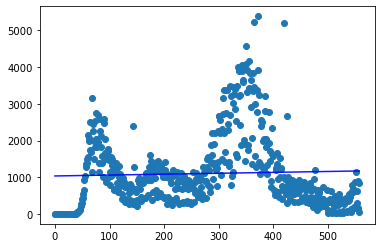

In [25]:
plt.scatter(new_deaths_trial.days_since, new_deaths_trial.new_deaths)
x = pd.DataFrame({'days_since': np.linspace(new_deaths_trial.days_since.min(), new_deaths_trial.days_since.max(), 558)})
X_new = pd.DataFrame({'days_since':[559,560,561,562,563,564,565]})

plt.plot(new_deaths_trial.days_since, lm_deaths.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % lm_deaths.rsquared, alpha=0.9)

#### Linear deaths Bias vs. Variance
This line shows high bias and low variance. It is not adequately descriptive of our data. 

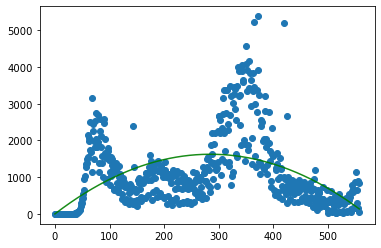

In [26]:
plt.scatter(new_deaths_trial.days_since, new_deaths_trial.new_deaths)

lm_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=new_deaths_trial).fit()
plt.plot(new_deaths_trial.days_since, lm_deaths_poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % 
         lm_deaths_poly_2.rsquared, alpha=0.9)


In [27]:
lm_deaths_poly_2.params

Intercept               -2.117173
days_since              11.433542
I(days_since ** 2.0)    -0.020088
dtype: float64

#### Polynomial deaths Bias vs. Variance
The line shows moderately high bias and moderately low variance. The line doesn't account for the two peaks but is still more accurate than the linear model.

In [28]:
lm_deaths.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8924
Date:                Thu, 28 Apr 2022   Prob (F-statistic):              0.345
Time:                        00:58:55   Log-Likelihood:                -4636.9
No. Observations:                 558   AIC:                             9278.
Df Residuals:                     556   BIC:                             9287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1034.7266     83.296     12.422      0.000     871.113    1198.340
days_since     0.2446      0.259      0.945      0.345      -0.264       0.753
==============================================================================
Omnibus:                      151.458   Durbin-Watson:                   0.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.153
Skew:                           1.486   Prob(JB):                     3.68e-69
Kurtosis:                       5.172   Cond. No.                         643.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
lm_deaths_poly_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             new_deaths   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     81.02
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           1.34e-31
Time:                        00:58:56   Log-Likelihood:                -4565.9
No. Observations:                 558   AIC:                             9138.
Df Residuals:                     555   BIC:                             9151.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.1172    109.864     -0.019      0.985    -217.918     213.683
days_since              11.4335      0.911     12.549      0.000       9.644      13.223
I(days_since ** 2.0)    -0.0201      0.002    -12.685      0.000      -0.023      -0.017
==============================================================================
Omnibus:                      156.963   Durbin-Watson:                   0.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              348.073
Skew:                           1.498   Prob(JB):                     2.61e-76
Kurtosis:                       5.449   Cond. No.                     4.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The polynomial is a better fit for our data as the r-squared is higher than that in our linear model.

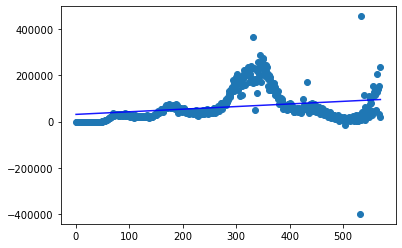

In [33]:
plt.scatter(new_cases_trial.days_since, new_cases_trial.new_cases)
x = pd.DataFrame({'days_since': np.linspace(new_cases_trial.days_since.min(), new_cases_trial.days_since.max(), 571)})


plt.plot(new_cases_trial.days_since, lm.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % lm.rsquared, alpha=0.9, scalex=False)

#### 7 Day forecast for cases

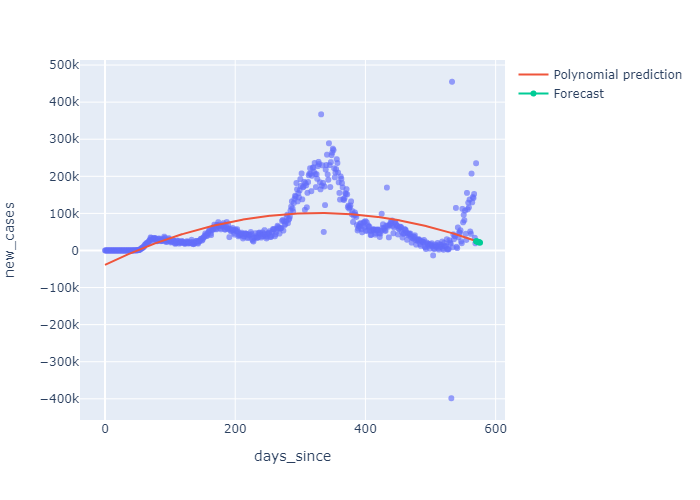

In [39]:
x = pd.DataFrame({'days_since': np.linspace(new_cases_trial.days_since.min(), new_cases_trial.days_since.max(), 571)})
X_new = pd.DataFrame({'days_since': [571,572,573,574,575,576,577]})
fig = px.scatter(new_cases_trial, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = new_cases_trial.days_since, y = lm_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = new_cases_trial.days_since + 570, y = lm_poly_2.predict(X_new), name='Forecast'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

As the polynomial regression is a better fit we can use it to better predict the future trend of new cases. From the prediction line we can see that there will be a gradual decrease in cases. At one week from the last day the value is predicted to be about 26 thousand, despite the sudden rise in cases in the last couple of recorded weeks.

#### 7 Day forecast for deaths

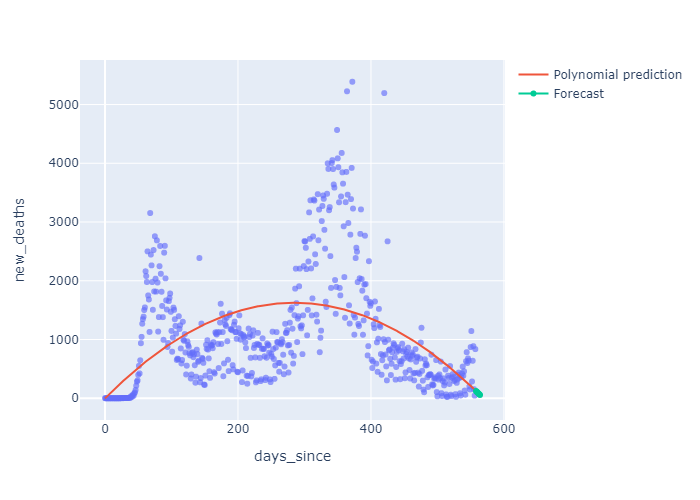

In [41]:
x = pd.DataFrame({'days_since': np.linspace(new_deaths_trial.days_since.min(), new_deaths_trial.days_since.max(), 558)})
X_new = pd.DataFrame({'days_since':[558,559,560,561,562,563,564]})
fig = px.scatter(new_deaths_trial, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = new_deaths_trial.days_since, y = lm_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = new_deaths_trial.days_since + 558, y = lm_deaths_poly_2.predict(X_new), name='Forecast'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

As the polynomial regression is a better fit we can use it to better predict the future trend of new deaths. From the prediction line we can see that there will be a gradual decrease in deaths. At one week from the last day the value is predicted to be about 134, despite the sudden rise in deaths in the last couple of recorded weeks.

### Country Comparisons

In [56]:
country_compare = pd.read_csv("../../../data/stage_2/owid-covid-data (1).csv")
all_countries = country_compare[['location', 'date', 'new_cases', 'new_deaths']].groupby('location')
chunks = dict(list(all_countries))
bangladesh = chunks['Bangladesh']
bangladesh = bangladesh.drop(['location', 'date'], axis=1)
brazil = chunks['Brazil']
brazil = brazil.drop(brazil.index[0:6],0)
brazil = brazil.drop(['location', 'date'], axis=1)
indonesia = chunks['Indonesia']
indonesia =  indonesia.drop(indonesia.index[0:1],0)
indonesia = indonesia.drop(['location', 'date'], axis=1)
nigeria = chunks['Nigeria']
nigeria =  nigeria.drop(nigeria.index[0:4],0)
nigeria = nigeria.drop(['location', 'date'], axis=1)
pakistan = chunks['Pakistan']
pakistan =  pakistan.drop(pakistan.index[0:7],0)
pakistan = pakistan.drop(['location', 'date'], axis=1)

C:\Users\lww11\AppData\Local\Temp/ipykernel_15460/3113945201.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\lww11\AppData\Local\Temp/ipykernel_15460/3113945201.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\lww11\AppData\Local\Temp/ipykernel_15460/3113945201.py:13: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\lww11\AppData\Local\Temp/ipykernel_15460/3113945201.py:16: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



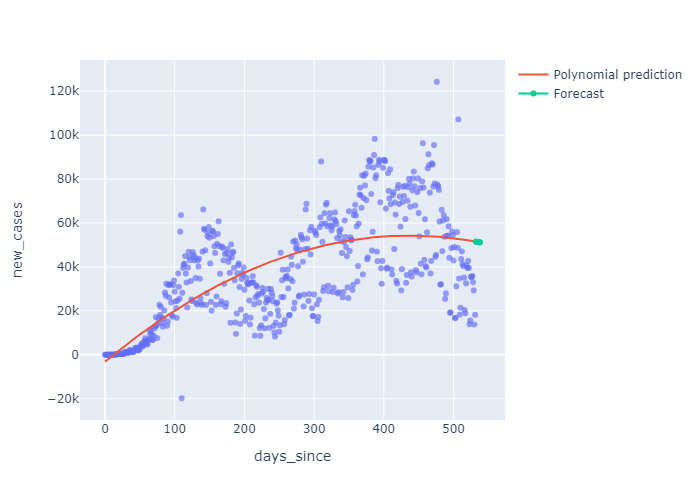

In [58]:
# Brazil Comparison (Sage)
brazil = brazil.fillna(0)
brazil = brazil.reset_index()
brazil = brazil.rename(columns={"index": "days_since"})
brazil['days_since'] = brazil['days_since'].apply(lambda x: x-538)

lm_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=brazil).fit()
lm_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=brazil).fit()

x = pd.DataFrame({'days_since': np.linspace(brazil.days_since.min(), brazil.days_since.max(), 532)})
X_new = pd.DataFrame({'days_since':[532,533,534,535,536,537,538]})
fig = px.scatter(brazil, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = brazil.days_since, y = lm_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = brazil.days_since + 532, y = lm_poly_2.predict(X_new), name='Forecast'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

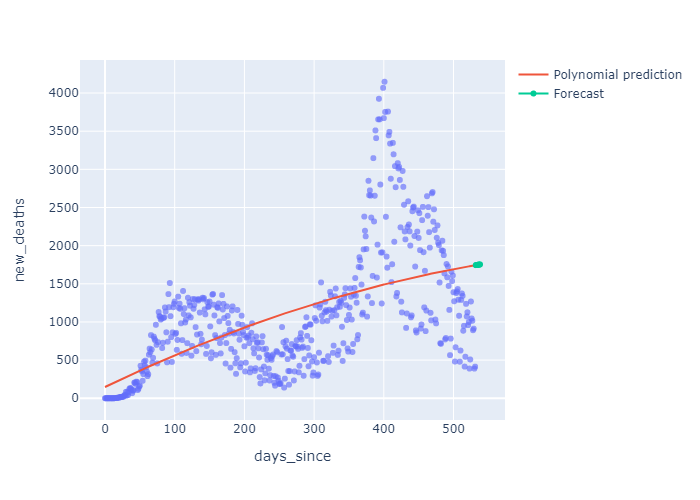

In [59]:
x = pd.DataFrame({'days_since': np.linspace(brazil.days_since.min(), brazil.days_since.max(), 532)})
X_new = pd.DataFrame({'days_since':[532,533,534,535,536,537,538]})
fig = px.scatter(brazil, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = brazil.days_since, y = lm_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = brazil.days_since + 532, y = lm_deaths_poly_2.predict(X_new), name='Forecast'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The polynomial prediction line predicts that in the next 7 days there will be a slight decrease in the number of new cases, but still an increase in the number of new deaths. Despite there being a large trough in the trends of new deaths, the prediction line has too high of a bias to accurately predict the trend. A more complex trend line might predict a decrease in new deaths over the next 7 days.

In [60]:
#Nigeria (Logan)
nigeria_data = nigeria.fillna(0)
nigeria_data = nigeria_data.reset_index()
nigeria_data = nigeria_data.rename(columns={"index": "days_since"})
nigeria_data.days_since = nigeria_data.days_since.apply(lambda x: x-1607)
nigeria_data

,days_since,new_cases,new_deaths
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
527,527,753.0,5.0
528,528,636.0,11.0
529,529,665.0,8.0
530,530,541.0,0.0


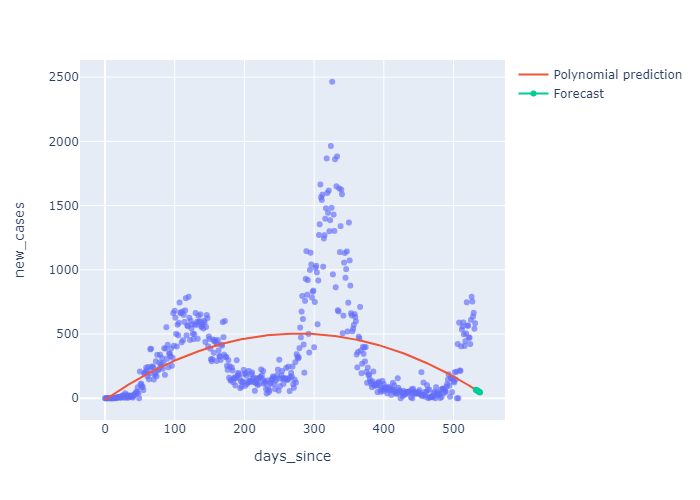

In [63]:
#Nigeria cases graph
n_poly_2 = smf.ols(formula='new_cases ~ days_since + I(days_since ** 2.0)', 
                    data=nigeria_data).fit()
x = pd.DataFrame({'days_since': np.linspace(nigeria_data.days_since.min(), nigeria_data.days_since.max(), 532)})
X_new = pd.DataFrame({'days_since':[532,533,534,535,536,537,538]})
fig = px.scatter(nigeria_data, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = nigeria_data.days_since, y = n_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = nigeria_data.days_since + 532, y = n_poly_2.predict(X_new), name='Forecast'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

Nigeria's new cases graph shows a predicted decrease in new cases from roughly 66 to 45 by day 7. The polynomial regression model shows heavy bias and may be counting on trends of peaks being immediatly followd by dips which may or may not be accurate considering the large ramp up in the final days of the collected data.

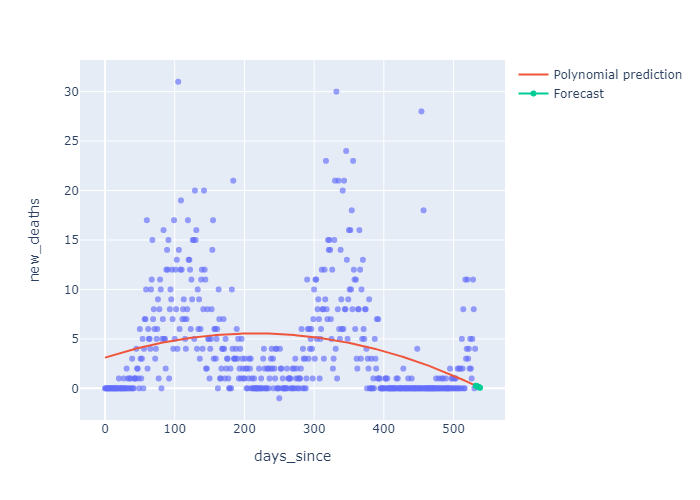

In [65]:
#Nigeria deaths graph
n_deaths_poly_2 = smf.ols(formula='new_deaths ~ days_since + I(days_since ** 2.0)', 
                    data=nigeria_data).fit()
x = pd.DataFrame({'days_since': np.linspace(nigeria_data.days_since.min(), nigeria_data.days_since.max(), 532)})
X_new = pd.DataFrame({'days_since':[532,533,534,535,536,537,538]})
fig = px.scatter(nigeria_data, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = nigeria_data.days_since, y = n_deaths_poly_2.predict(x), name='Polynomial prediction'))
fig.add_trace(go.Scatter(x = nigeria_data.days_since + 532, y = n_deaths_poly_2.predict(X_new), name='Forecast'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The Nigerian death graph shows a downward trend in the predicted number of deaths from 0.2652 to 0.0628 over the following week. The data present seems to have really high variance and the regression model appears to show heavy bias so it makes the best sense it can of the data but the overall prediction is hard to trust.

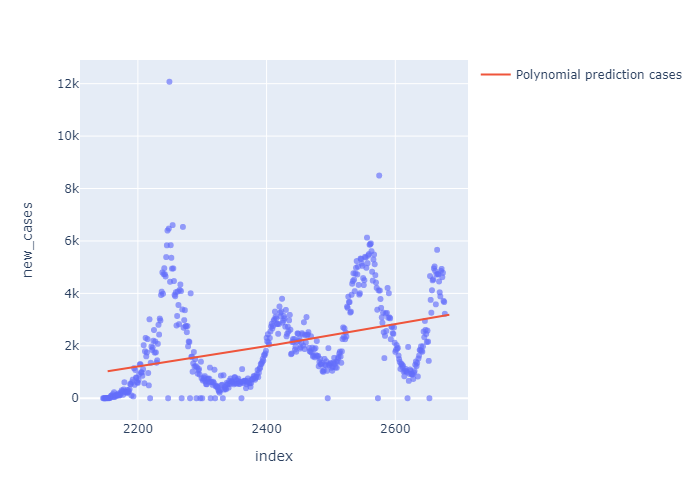

In [71]:
#pakistan comparison Alyiah
pakistan = pakistan.fillna(0)

#fitting models 
pk_poly_2 = smf.ols(formula='new_cases ~ 1 + pakistan.index + I(pakistan.index ** 2.0)',data = pakistan).fit()
pk_deaths_poly_2 = smf.ols(formula='new_deaths ~ 1 + pakistan.index + I(pakistan.index ** 2.0)', data=pakistan).fit()

#plotting the cases prediction 
x = pd.DataFrame({'pakistan.index': np.linspace(pakistan.index.min(),pakistan.index.max(), 532)})
fig = px.scatter(pakistan, x= pakistan.index, y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = pakistan.index + 7, y = pk_poly_2.predict(x), name='Polynomial prediction cases'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

From the prediction line we can see that there will be a gradual increase in cases. At one week from the last day the value is predicted to be about 3 thousand cases. Compared to the us the amount of new cases is significantly lower, and the trend continues to rise while for the US the trend tends to fall. We can also note that the line, while being polynomial, still has high variance and apears to be quite linear. 

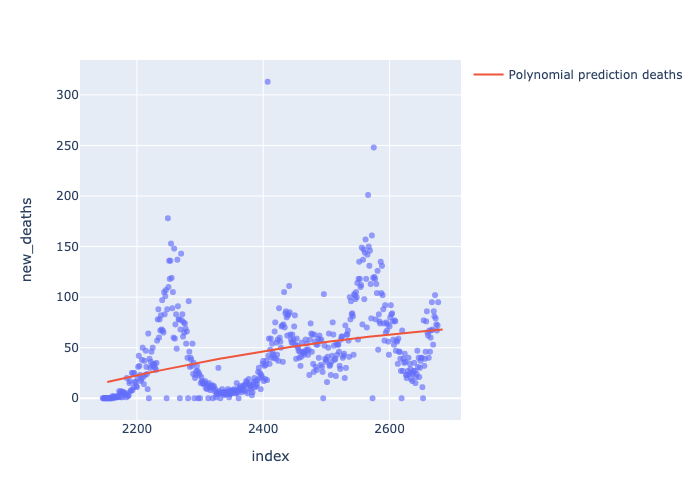

In [34]:
#plotting the deaths prediction 
x = pd.DataFrame({'pakistan.index': np.linspace(pakistan.index.min(),pakistan.index.max(), 532)})
fig = px.scatter(pakistan, x= pakistan.index, y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = pakistan.index + 7, y = pk_deaths_poly_2.predict(x), name='Polynomial prediction deaths'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

From the prediction line we can see that there will be a gradual increase in deaths. At one week from the last day the value is predicted to be about 68 deaths. Compared to the US the amount of new deaths is  lower, and the trend continues to rise while for the US the trend tends to fall

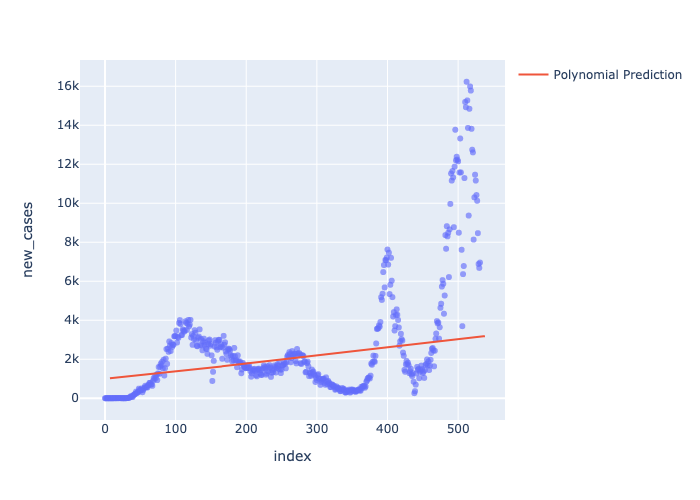

In [35]:
# Bangladesh Comparison (Jacky)

# Dropping redundant data
bangladesh = bangladesh.fillna(0)
bangladesh = bangladesh.reset_index()
bangladesh = bangladesh.rename(columns={"index": "days_since"})

# Caculating data for graph
bangladesh_poly_2 = smf.ols(formula='new_cases ~ 1 + bangladesh.index + I(bangladesh.index ** 2.0)',data = bangladesh).fit()
bangladesh_poly_2 = smf.ols(formula='new_deaths ~ 1 + bangladesh.index + I(bangladesh.index ** 2.0)', data=bangladesh).fit()

# Adding 7 to get a prediction of data for the next week (prediction of cases)
x = pd.DataFrame({'bangladesh.index': np.linspace(bangladesh.index.min(),bangladesh.index.max(), 532)})
fig = px.scatter(bangladesh, x= bangladesh.index, y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = bangladesh.index + 7, y = pk_poly_2.predict(x), name='Polynomial Prediction'))

# Displaying graph
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The polynomial prediction line above predicts that Bangladesh will see a slight dip in cases and then see a slight rise in cases. Looking at recent covid-19 data from Bangladesh this seems like a reasonable prediction as it looks like Bangladesh is coming out of a surge, hence the dip in cases. When comparing to the United States, there is a huge difference as Bangladesh only sees double digit covid cases while US cases are still declining (still tens of thousands) from the Omicron surge. We can also note that the line has not high but also not low variance. A potential hypothesis could be are countries with lower covid trends easier to predict?

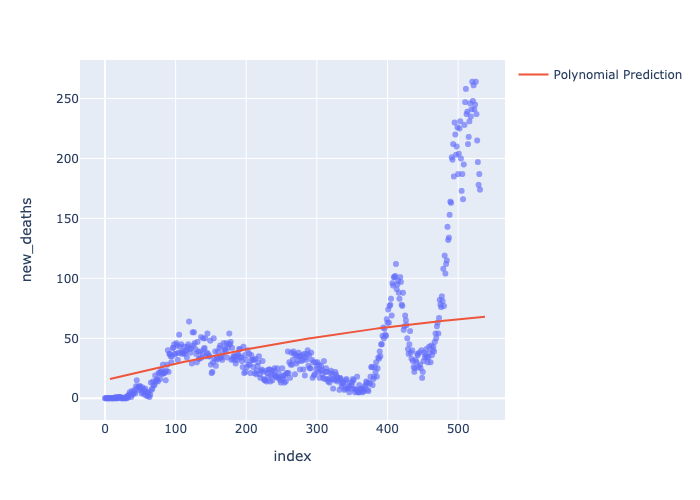

In [36]:
x = pd.DataFrame({'bangladesh.index': np.linspace(bangladesh.index.min(),bangladesh.index.max(), 532)})
fig = px.scatter(bangladesh, x= bangladesh.index, y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = bangladesh.index + 7, y = pk_deaths_poly_2.predict(x), name='Polynomial Prediction'))
#Displaying graph
img_bytes = fig.to_image(format="png")
Image(img_bytes)

The polynomial pediction line above predicts that Bangladesh will see a slight increase in deaths. Similarily to cases, when compared to the United States, Bangladesh still sees a very low amount of deaths. Overall it still safe to say Bangladesh is seeing a decrease in overall covid trends as compared to the United States. THe US however is also seeing a decrease in covid trends as well.

In [37]:
# Indonesia (Annie)
indonesia = indonesia.fillna(0)
indonesia = indonesia.reset_index()
indonesia = indonesia.rename(columns={"index": "days_since"})
indonesia['days_since'] = indonesia['days_since'].apply(lambda x: x-538)
indonesia

,days_since,new_cases,new_deaths
0,533,0.0,0.0
1,534,0.0,0.0
2,535,0.0,0.0
3,536,2.0,0.0
4,537,0.0,0.0
...,...,...,...
527,1060,24709.0,1466.0
528,1061,30788.0,1432.0
529,1062,28598.0,1270.0
530,1063,20813.0,1222.0


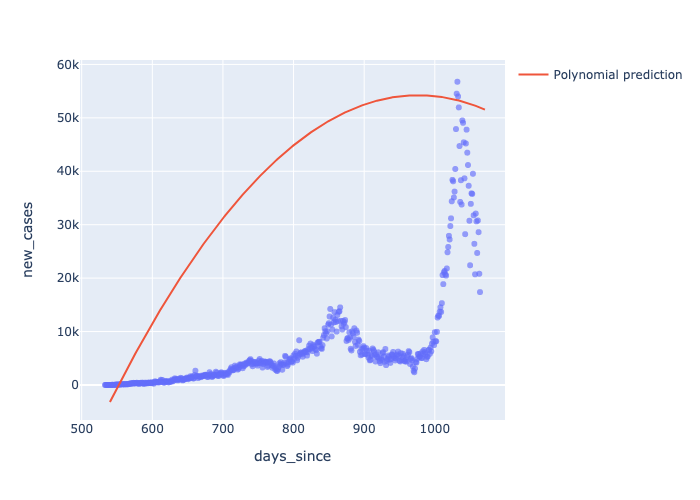

In [38]:
id_poly_2 = smf.ols(formula='new_cases ~ 1 + indonesia.days_since + I(indonesia.days_since ** 2.0)', 
                    data=indonesia).fit()
id_deaths_poly_2 = smf.ols(formula='new_deaths ~ 1 + indonesia.days_since + I(indonesia.days_since ** 2.0)', 
                    data=indonesia).fit()

# Cases
x = pd.DataFrame({'days_since': np.linspace(indonesia.days_since.min(), indonesia.days_since.max(), 532)})
fig = px.scatter(indonesia, x='days_since', y='new_cases', opacity=0.65)
fig.add_trace(go.Scatter(x = indonesia.days_since + 7, y = lm_poly_2.predict(x), name='Polynomial prediction'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In the polynomial prediction for cases, Indonesia saw a great increase but then the prediction line decreases a bit to 51 thousand cases. The difference between Indonesia and the US is that the US saw a gradual increase while Indonesia saw a rapid increase.

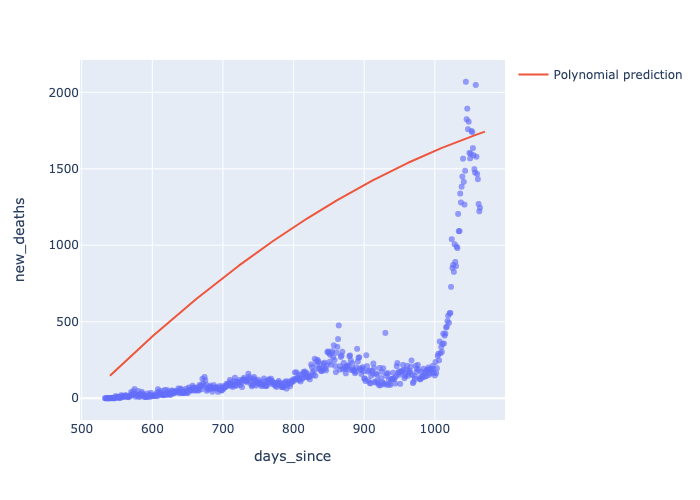

In [39]:
# Deaths
x = pd.DataFrame({'days_since': np.linspace(indonesia.days_since.min(), indonesia.days_since.max(), 532)})
fig = px.scatter(indonesia, x='days_since', y='new_deaths', opacity=0.65)
fig.add_trace(go.Scatter(x = indonesia.days_since + 7, y = lm_deaths_poly_2.predict(x), name='Polynomial prediction'))
#fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In the polynomial prediction for deaths, Indonesia saw a great increase and the prediction line went on to predict about 1,700 deaths. Again, the difference between Indonesia and the US is that the US saw a gradual increase while Indonesia saw a rapid increase.